In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Tesi')

In [ ]:
import cv2
import math
import copy
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.utils import Sequence

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sequence_length = 4
sequence_stride = 2
batch_size      = 16

# Network model

## Loading the pre-trained model

In [ ]:
sn_path = 'models/wild/SN_wild_pre-trained.h5'
sn = load_model(sn_path)

# sn.summary()

## Remove the last layers

In [ ]:
from keras import Model

sn_nofreeze = Model(inputs=mnv2.input, outputs=mnv2.layers[-4].output)

for layer in sn_nofreeze.layers:
  layer.trainable = True

# sn_nofreeze.summary()

## CNN + LSTM

In [ ]:
from keras.layers import TimeDistributed, Input, LSTM, Dense, Dropout

input_layer = Input(shape=(sequence_length, 224, 224, 3))
sn_reshaped = TimeDistributed(sn_nofreeze)(input_layer)
CNNandLSTM = LSTM(100, activation='relu')(sn_reshaped)
dropout = Dropout(0.5)(CNNandLSTM)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.summary()

In [ ]:
model.save('models/wild/SN_LSTM_wild_trainable_True.h5')

# Inference with pre-trained CNN on single test frames

In [ ]:
path = 'csv/Test/wild/KFold_short-range/fold3'
csvs = os.listdir(path)
test_data = {'filename':[], 'Flames':[]}

for csv in csvs:
    temp = pd.read_csv(path + '/' + csv)
    for index, row in temp.iterrows():
      test_data['filename'].append(row['filename'])
      test_data['Flames'].append(row['Flames'])

test_data = pd.DataFrame(test_data)
print("Test data samples: " + str(len(test_data)) + ".\nPositive test frames: " +
      str(test_data[test_data['Flames'] == 1].count()[0]) + ".\nNegative test frames: " +
      str(test_data[test_data['Flames'] == 0].count()[0]) + ".")

In [ ]:
# putting our test data labels in the proper format and shape desired
col = test_data['Flames']
col = list(col)

t = []
for i in col:
  t.append(str(i))

td = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  td['filename'].append(row['filename'])
  td['Flames'].append(t[index])

test_data = pd.DataFrame(td)

In [ ]:
new_test_data = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  new_test_data['filename'].append('/content/drive/My Drive' + row['filename'][30:])
  new_test_data['Flames'].append(str(row['Flames']))

n_t_d = pd.DataFrame(new_test_data)

In [ ]:
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

test_datagen = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.mobilenet_v2.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe = n_t_d, 
                                                    x_col='filename', 
                                                    y_col='Flames', 
                                                    class_mode='binary',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    shuffle=False)

In [ ]:
from keras.models import load_model

mnv2_path = 'models/wild/SN_wild_pre-trained.h5'
mnv2 = load_model(mnv2_path)

pred = mnv2.predict(test_generator)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = pred.argmax(-1)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

In [ ]:
test_lab = []
for i in list(n_t_d['Flames']):
  test_lab.append(int(i))
plot_cm(y=test_lab, pred=pred)

# Evaluate

In [ ]:
class DataGenerator(Sequence):

    def __init__(self, data, batch_size, shuffle_data, aug):
        self.num_samples = len(data)
        self.data = shuffle(data) if shuffle_data else data
        self.batch_size = batch_size
        self.aug = aug        
        self.additional_targets = {[f'image{i}' for i in range(sequence_length-1)][j]:'image' for j in range(sequence_length-1)}

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        #print('starting index: ', idx * self.batch_size)
        batch_samples = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
            x = batch_sample[0]   # Load image (X)
            y = batch_sample[1]   # Read label (y)
            temp_data_list = []
            for img_name in x:
                try:
                    img = cv2.imread(img_name)
                    img = cv2.resize(img, (224,224))
                    temp_data_list.append(img[:,:, ::-1])
                except Exception as e:
                    print(e)
                    print('error reading file: ', img_name)
            # if self.aug:
            #     temp_data_list = self.__totransform__(temp_data_list)
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)
        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        return X_train, y_train

In [ ]:
def file_generator(data_path, data_files, temporal_stride, temporal_length):
  '''
  data_files - list of csv files to be read
  '''
  for f in data_files:
    tmp_df = pd.read_csv(os.path.join(data_path, f))
    total_images = len(tmp_df)
    if total_images >= temporal_length:
      num_samples = int((total_images - temporal_length)/temporal_stride) + 1
      #print('num of samples from vid seq-{}: {}'.format(f, num_samples))
    else:
      #print('num of frames is less than temporal length; hence discarding this \
      #      file-{}'.format(f))
      continue

    samples = deque()
    labels = deque()

    for index, row in tmp_df.iterrows():
      samples.append('/content/drive/My Drive' + row['filename'][30:])
      labels.append(int(row['Flames']))
      if len(samples) == temporal_length:
        to_delete = False
        if labels.count(labels[0]) != len(labels):
          to_delete = True
        samples_c = copy.deepcopy(samples)
        for t in range(temporal_stride):
          samples.popleft()
          labels.popleft()
        if to_delete: continue
        yield samples_c, labels[0]

def load_samples(CSV_folder, temporal_stride, temporal_length):
  data_path = os.path.join('csv', CSV_folder)
  data_files = os.listdir(data_path)
  file_gen = file_generator(data_path, data_files, temporal_stride, temporal_length)
  iterator = True
  data_list = []

  while iterator:
    try:
      x, y = next(file_gen)
      x = list(x)
      data_list.append([x, y])
    except Exception as e:
      #print('Exception: ', e)
      iterator = False
      #print('end of data generator ')
  return data_list

test_data = load_samples(CSV_folder='Test/wild/KFold_short-range/fold3', 
                            temporal_stride=sequence_stride,
                            temporal_length=sequence_length)

test_gen = DataGenerator(data=test_data, batch_size=batch_size, 
                         shuffle_data=False, aug=False)

46/46 [==============================] - 702s 16s/step


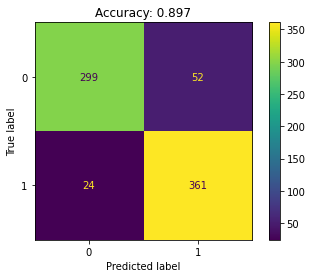

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = []
  for i in pred:
    p.append(round(list(i)[0]))
  p = np.array(p)
  y = np.array(y)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

model = load_model('models/wild/short-range/SqueezeNet/case12/case12_best_model3.h5')

test_labels = []
for test in range(len(test_data)):
  test_labels.append(test_data[test][1])

pred = model.predict(test_gen)
plot_cm(y=test_labels, pred=list(pred))

In [ ]:
model.evaluate(test_gen)

46/46 [==============================] - 147s 3s/step - loss: 0.3871 - accuracy: 0.8967


[0.3870954215526581, 0.89673912525177]

In [ ]:
p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)
y = np.array(test_labels)

test_labels = list(y)
scores = list(p)

In [ ]:
from keras.metrics import AUC # Approximates the Area Under the Curve of the ROC curve
from sklearn.metrics import balanced_accuracy_score

b_acc = balanced_accuracy_score(y_true=y, y_pred=p)

TP=TN=FP=FN = 0

for i in range(len(test_labels)):
    if test_labels[i] == 1 and scores[i] == 1:
        TP = TP + 1
    elif test_labels[i] == 0 and scores[i] == 0:
        TN = TN + 1
    elif test_labels[i] == 0 and scores[i] == 1:
        FP = FP + 1
    elif test_labels[i] == 1 and scores[i] == 0:
        FN = FN + 1

AR = (TP + TN)/(TP + TN + FP + FN)
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
TPR = TP/(TP + FN)
TNR = TN/(TN + FP)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
F1score = (2 * Precision * Recall)/(Precision + Recall)
Auc = AUC()
Auc.update_state(test_labels, scores)

print("True Positives: " + str(TP) + "\nTrue Negatives: " + str(TN) + 
      "\nFalse Positives: " + str(FP) + "\nFalse Negatives: " + str(FN) +
      "\nTrue Positive rate: " + str(round(TPR, 3)) + "\nTrue negative rate: " +
      str(round(TNR, 3)) + "\nFalse Positive rate: " + str(round(FPR, 3)) +
      "\nFalse Negative rate: " + str(round(FNR, 3)) + "\nAccuracy Rate: " + 
      str(round(AR, 3)) + "\nPrecision: " + str(round(Precision, 3)) + 
      "\nRecall: " + str(round(Recall, 3)) + "\nBalanced accuracy: " + 
      str(round(b_acc, 3)) + "\nF1-Score: " + str(round(F1score, 3)) + 
      "\nArea under ROC curve: " + str(round(float(Auc.result()), 3)))

True Positives: 361
True Negatives: 299
False Positives: 52
False Negatives: 24
True Positive rate: 0.938
True negative rate: 0.852
False Positive rate: 0.148
False Negative rate: 0.062
Accuracy Rate: 0.897
Precision: 0.874
Recall: 0.938
Balanced accuracy: 0.895
F1-Score: 0.905
Area under ROC curve: 0.895


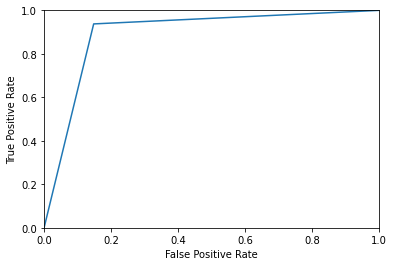

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()

p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=np.array(test_labels), y_score=p)
plot_roc_curve(fpr_keras,tpr_keras)

## Which samples are wrongly predicted?

In [ ]:
wrong_predictions01 = []
wrong_predictions10 = []

for i in range(len(test_labels)):
    if test_data[i][1] == 0 and scores[i] == 1:
      wrong_predictions01.append(test_data[i][0])
    elif test_data[i][1] == 1 and scores[i] == 0:
      wrong_predictions10.append(test_data[i][0])

In [ ]:
wrong_predictions01

[['/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/background-trees-in-the-forest-shining-with-the-sun-beautiful-autumn-nature-fo-SBV-329242029-preview.mp4/1.jpg',
  '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/background-trees-in-the-forest-shining-with-the-sun-beautiful-autumn-nature-fo-SBV-329242029-preview.mp4/2.jpg',
  '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/background-trees-in-the-forest-shining-with-the-sun-beautiful-autumn-nature-fo-SBV-329242029-preview.mp4/3.jpg',
  '/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/background-trees-in-the-forest-shining-with-the-sun-beautiful-autumn-nature-fo-SBV-329242029-preview.mp4/4.jpg'],
 ['/content/drive/My Drive/Tesi/datasets/wild/short-range/Storyblocks/frames/negative/background-trees-in-the-forest-shining-with-the-sun-beautiful-autumn-nature-fo-SBV-329242029-preview.mp4/3.jpg',
  '/

In [ ]:
wp01 = []
for i in range(len(wrong_predictions01)):
  idx_of_last_slash = wrong_predictions01[i][0][54:][::-1].index('/') + 1
  str_ = wrong_predictions01[i][0][54:-idx_of_last_slash]
  if str_ not in wp01:
    wp01.append(str_)
for i in wp01:
  print(i)

/Storyblocks/frames/negative/background-trees-in-the-forest-shining-with-the-sun-beautiful-autumn-nature-fo-SBV-329242029-preview.mp4
/Storyblocks/frames/negative/river-in-mysterious-forest-with-fog-SBV-346824880-preview.mp4
/Storyblocks/frames/negative/scenic-forest-of-fresh-green-deciduous-trees-framed-by-leaves-SBV-334511965-preview.mp4
/Storyblocks/frames/negative/tall-trees-silhouette-in-front-of-the-milky-way-SBV-338826696-preview.mp4
/Storyblocks/frames/negative/wild-pine-forest-at-sunrise-SBV-338603828-preview.mp4


In [ ]:
wrong_predictions10

[['/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/1.jpg',
  '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/2.jpg',
  '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/3.jpg',
  '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/4.jpg'],
 ['/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4/3.jpg',
  '/content/drive/My Drive/Tesi/datasets/wild/short-range/Depositphotos/frames/positive/depositphotos_5348217

In [ ]:
wp10 = []
for i in range(len(wrong_predictions10)):
  idx_of_last_slash = wrong_predictions10[i][0][54:][::-1].index('/') + 1
  str_ = wrong_predictions10[i][0][54:-idx_of_last_slash]
  if str_ not in wp10:
    wp10.append(str_)
for i in wp10:
  print(i)

/Depositphotos/frames/positive/depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4


In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions10[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions10:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong10 = pd.DataFrame(all_videos)

In [ ]:
df_wrong10

,name,num
0,depositphotos_534821736-stock-video-field-carp...,24


In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions01[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions01:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong01 = pd.DataFrame(all_videos)
df_wrong01

,name,num
0,background-trees-in-the-forest-shining-with-th...,9
1,river-in-mysterious-forest-with-fog-SBV-346824...,9
2,scenic-forest-of-fresh-green-deciduous-trees-f...,1
3,tall-trees-silhouette-in-front-of-the-milky-wa...,23
4,wild-pine-forest-at-sunrise-SBV-338603828-prev...,10


In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = test_data[0][0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in test_data:
  video_name = list_of_lists[0][0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df = pd.DataFrame(all_videos)
df

,name,num
0,forest3.avi,10
1,depositphotos_241227250-stock-video-close-camp...,31
2,depositphotos_367618068-stock-video-forest-fir...,5
3,depositphotos_402052830-stock-video-forest-fir...,20
4,depositphotos_409156282-stock-video-night-vide...,29
5,depositphotos_455107056-stock-video-forest-fir...,24
6,depositphotos_462622938-stock-video-burning-fi...,13
7,depositphotos_466384010-stock-video-timanfaya-...,11
8,depositphotos_475663600-stock-video-forest-fir...,14
9,depositphotos_534821736-stock-video-field-carp...,24


In [ ]:
for index,row in df.iterrows():
  print(row['name'])

forest3.avi
depositphotos_241227250-stock-video-close-campfire-mountain-river-rocky.mp4
depositphotos_367618068-stock-video-forest-fire-fire-destroys-trees.mp4
depositphotos_402052830-stock-video-forest-fire-disaster-burning-caused.mp4
depositphotos_409156282-stock-video-night-video-bonfire-tourist-camp.mp4
depositphotos_455107056-stock-video-forest-fire-disaster-burning-caused.mp4
depositphotos_462622938-stock-video-burning-fire-in-slow-motion.mp4
depositphotos_466384010-stock-video-timanfaya-parque-nacional-de-timanfaya.mp4
depositphotos_475663600-stock-video-forest-fire-disaster-burning-caused.mp4
depositphotos_534821736-stock-video-field-carpathian-mountains-village-bright.mp4
depositphotos_550140240-stock-video-wildfire-disaster-burning-tropical-forest.mp4
depositphotos_604889248-stock-video-campfire-mountain-camp-fire-burning.mp4
depositphotos_61412485-stock-video-wildfire-in-mountain-of-thailandpan.mp4
a-beautiful-forest-on-a-sunny-day-SBV-336251067-preview.mp4
arson-fire-danger